## Pre-processing

In [158]:
from google.colab import files
upload = files.upload() # Upload the data

Saving data_ready_231029.csv to data_ready_231029 (1).csv


In [159]:
import pandas as pd

original_df = pd.read_csv("data_ready_231029.csv")
grouped = original_df.groupby(['lab', 'compound'])
material_list = list(grouped.groups.keys())

In [160]:
original_df.head()

,lab,compound,sample_type,RT,sample,peak_area,note,c_real_M
0,L1,Amitrole,cal,0.72,cal1,2.856002e+08,non-linear,6.250000e-06
1,L1,Amitrole,cal,0.72,cal2,1.030577e+08,non-linear,2.580000e-06
2,L1,Amitrole,cal,0.72,cal3,6.593301e+07,non-linear,1.340000e-06
3,L1,Amitrole,cal,0.72,cal4,3.805867e+07,non-linear,7.780000e-07
4,L1,Amitrole,cal,0.72,cal5,1.340538e+07,linear,2.350000e-07


### Data Cleaning

### Quantity of each material

In [164]:
original_df["quantity"].value_counts()

6.0    2844
5.0     710
4.0     208
3.0     102
Name: quantity, dtype: int64

So...<br>
* 1: 14 materials
* 2: 27 materials
* 3: 34 materials

In [161]:
for (lab, compound), df in grouped:
  if df[["peak_area", "c_real_M"]].isnull().values.any():
    # (L11, Butocarboxim_Na) has NA c_real_M
    original_df.drop(df.index, axis='index', inplace=True)
    continue
  df["quantity"] = len(df)
  original_df.loc[df.index, ["quantity"]] = df[["quantity"]]

original_df.drop(original_df[(original_df["quantity"] == 1) | (original_df["quantity"] == 2)].index, inplace=True)
grouped = original_df.groupby(['lab', 'compound'])

In [ ]:
len(original_df)

3878

In [165]:
grouped = original_df.groupby(['lab', 'compound'])
material_list = list(grouped.groups.keys())

### Add Basic features (residual, relative residual, RF)

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np

for (lab, compound), df in grouped:
  if df[["peak_area", "c_real_M"]].isnull().values.any():
    # (L11, Butocarboxim_Na) has NA c_real_M
    original_df.drop(df.index, axis='index', inplace=True)
    continue

  linear_label_number = 0
  nonlinear_label_number = 0
  for row in df.iterrows():
    label = row[1]['note']
    if label == "linear":
      linear_label_number += 1
    elif label == "non-linear":
      nonlinear_label_number += 1
  df["linear_label_number"] = linear_label_number
  df["nonlinear_label_number"] = nonlinear_label_number
  df['linear_label_percentage'] = linear_label_number / len(df)

  if linear_label_number == len(df):
    df["class"] = 0
  elif nonlinear_label_number == len(df):
    df['class'] = 2
  else:
    df["class"] = 1

  peak_area = df["peak_area"].values.reshape(-1, 1)
  c_real_M = df["c_real_M"].values.reshape(-1, 1)

  model = LinearRegression()
  model.fit(c_real_M, peak_area)

  sm_model = sm.OLS(df["peak_area"], df["c_real_M"]).fit()
  influence = sm_model.get_influence()
  cook_dist = influence.cooks_distance[0]
  leverage = influence.hat_matrix_diag
  dffits = influence.dffits[0]

  df["predicted_peak_area"] = model.predict(c_real_M)
  df["residual"] = df["peak_area"] - df["predicted_peak_area"]
  df["relative_residual"] = df["residual"] / df["predicted_peak_area"]
  df["avg_relative_residual"] = sum(abs(df["relative_residual"].values)) / len(df)

  df["RF"] = StandardScaler().fit_transform(np.array(df["peak_area"] / df["c_real_M"]).reshape(-1, 1))
  df["MSE"] = mean_squared_error(df["predicted_peak_area"], df["peak_area"])
  df["coef_0"] = model.intercept_[0]
  df["coef_1"] = model.coef_[0][0]
  df["cook_dist"] = cook_dist
  df["leverage"] = leverage
  df["abs_dffits"] = abs(dffits)

  #####
  max_abs_dffits = df["abs_dffits"].max()
  filtered_1_df = df[df["abs_dffits"] != max_abs_dffits].copy()
  filtered_1_sm_model = sm.OLS(filtered_1_df["peak_area"], filtered_1_df["c_real_M"]).fit()
  filtered_1_influence = filtered_1_sm_model.get_influence()
  filtered_1_dffits = filtered_1_influence.dffits[0]
  filtered_1_df["filtered_abs_dffits"] = abs(filtered_1_dffits)

  #####
  max_abs_dffits = filtered_1_df["filtered_abs_dffits"].max()
  filtered_2_df = filtered_1_df[filtered_1_df["filtered_abs_dffits"] != max_abs_dffits].copy()

  # re-calculate regression line
  filtered_2_peak_area = filtered_2_df["peak_area"].values.reshape(-1, 1)
  filtered_2_c_real_M = filtered_2_df["c_real_M"].values.reshape(-1, 1)

  filtered_2_model = LinearRegression()
  filtered_2_model.fit(filtered_2_c_real_M, filtered_2_peak_area)

  df["filtered_predicted_peak_area"] = filtered_2_model.predict(c_real_M)
  df["filtered_residual"] = df["peak_area"] - df["filtered_predicted_peak_area"]
  df["filtered_relative_residual"] = df["filtered_residual"] / df["filtered_predicted_peak_area"]


  # Update
  original_df.loc[df.index, ["linear_label_number", "nonlinear_label_number", "linear_label_percentage", "class", "predicted_peak_area", "residual", "filtered_residual", "relative_residual", "filtered_relative_residual", "avg_relative_residual", "RF", "MSE", "coef_0", "coef_1", "cook_dist", "leverage", "abs_dffits"]] = \
    df[["linear_label_number", "nonlinear_label_number", "linear_label_percentage", "class", "predicted_peak_area", "residual", "filtered_residual", "relative_residual", "filtered_relative_residual", "avg_relative_residual", "RF", "MSE", "coef_0", "coef_1", "cook_dist", "leverage", "abs_dffits"]]

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: inva

KeyboardInterrupt: ignored

### Add polynomial regression feature

In [166]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

for (lab, compound), df in grouped:
  if df[["peak_area", "c_real_M"]].isnull().values.any():
    # (L11, Butocarboxim_Na) has NA c_real_M
    original_df.drop(df.index, axis='index', inplace=True)
    continue

  peak_area = df["peak_area"].values.reshape(-1, 1)
  c_real_M = df["c_real_M"].values.reshape(-1, 1)

  poly = PolynomialFeatures(degree=2)
  poly_features = poly.fit_transform(c_real_M)

  poly_model = LinearRegression()
  poly_model.fit(poly_features, peak_area)

  df["poly_predicted_peak_area"] = poly_model.predict(poly_features)
  df["poly_residual"] = df["peak_area"] - df["poly_predicted_peak_area"]
  df["poly_relative_residual"] = df["poly_residual"] / df["poly_predicted_peak_area"]
  df["poly_MSE"] = mean_squared_error(df["poly_predicted_peak_area"], df["peak_area"])
  df["poly_coef_0"] = poly_model.coef_[0][0]
  df["poly_coef_1"] = poly_model.coef_[0][1]
  df["poly_coef_2"] = poly_model.coef_[0][2]

  # Update
  original_df.loc[df.index, ["poly_predicted_peak_area", "poly_residual", "poly_relative_residual", "poly_MSE", "poly_coef_0", "poly_coef_1", "poly_coef_2"]] = \
    df[["poly_predicted_peak_area", "poly_residual", "poly_relative_residual", "poly_MSE", "poly_coef_0", "poly_coef_1", "poly_coef_2"]]

In [163]:
original_df.head()

,lab,compound,sample_type,RT,sample,peak_area,note,c_real_M,quantity,linear_label_number,...,relative_residual,filtered_relative_residual,avg_relative_residual,RF,MSE,coef_0,coef_1,cook_dist,leverage,abs_dffits
0,L1,Amitrole,cal,0.72,cal1,2.856002e+08,non-linear,6.250000e-06,6.0,2.0,...,0.014625,-0.058147,0.106838,-0.653189,3.939377e+13,667276.695113,4.493062e+13,6.928833,0.810839,2.862019
1,L1,Amitrole,cal,0.72,cal2,1.030577e+08,non-linear,2.580000e-06,6.0,2.0,...,-0.116055,-0.180479,0.106838,-1.363077,3.939377e+13,667276.695113,4.493062e+13,0.687896,0.138170,1.969621
2,L1,Amitrole,cal,0.72,cal3,6.593301e+07,non-linear,1.340000e-06,6.0,2.0,...,0.083101,0.002204,0.106838,-0.220223,3.939377e+13,667276.695113,4.493062e+13,0.025738,0.037272,0.154103
3,L1,Amitrole,cal,0.72,cal4,3.805867e+07,non-linear,7.780000e-07,6.0,2.0,...,0.068365,-0.014282,0.106838,-0.255419,3.939377e+13,667276.695113,4.493062e+13,0.002408,0.012564,0.044750
4,L1,Amitrole,cal,0.72,cal5,1.340538e+07,linear,2.350000e-07,6.0,2.0,...,0.194140,0.085369,0.106838,0.747543,3.939377e+13,667276.695113,4.493062e+13,0.000191,0.001146,0.012563


## Analysis of the data

### Random sampling & Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_analysis(df):
  fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3,2, figsize=(11,11))
  plt.subplots_adjust(wspace=0.4, hspace=0.4)

  colors = {'non-linear':'red', 'linear':'blue'}
  lab = df.iloc[0]["lab"]
  compound = df.iloc[0]["compound"]

  ax1.scatter(x=df[df["note"]=="linear"]["c_real_M"], y=df[df["note"]=="linear"]["peak_area"], c=colors["linear"], label="linear")
  ax1.scatter(x=df[df["note"]=="non-linear"]["c_real_M"], y=df[df["note"]=="non-linear"]["peak_area"], c=colors["non-linear"], label="non-linear")
  ax1.plot(df["c_real_M"], df["predicted_peak_area"], "--")
  ax1.plot(df["c_real_M"], df["poly_predicted_peak_area"], "--")
  ax1.legend()
  ax1.set_title(f"({lab} {compound})\n peak vs consentration")
  ax1.set_xlabel("c_real_M")
  ax1.set_ylabel("peak_area")

  ax2.scatter(x=df[df["note"]=="linear"]["c_real_M"], y=df[df["note"]=="linear"]["residual"], c=colors["linear"], label="linear")
  ax2.scatter(x=df[df["note"]=="non-linear"]["c_real_M"], y=df[df["note"]=="non-linear"]["residual"], c=colors["non-linear"], label="non-linear")
  ax2.legend()
  ax2.set_title(f"({lab} {compound})\n residual vs consentration")
  ax2.set_xlabel("c_real_M")
  ax2.set_ylabel("residual")

  ax3.scatter(x=df[df["note"]=="linear"]["c_real_M"], y=df[df["note"]=="linear"]["relative_residual"], c=colors["linear"], label="linear")
  ax3.scatter(x=df[df["note"]=="non-linear"]["c_real_M"], y=df[df["note"]=="non-linear"]["relative_residual"], c=colors["non-linear"], label="non-linear")
  ax3.axhline(y=-0.2, linewidth=1, ls="--")
  ax3.axhline(y=0.2, linewidth=1, ls="--")
  ax3.legend()
  ax3.set_title(f"({lab} {compound})\n relative-residual vs consentration")
  ax3.set_xlabel("c_real_M")
  ax3.set_ylabel("relative residual")

  ax4.scatter(x=df[df["note"]=="linear"]["c_real_M"], y=df[df["note"]=="linear"]["RF"], c=colors["linear"], label="linear")
  ax4.scatter(x=df[df["note"]=="non-linear"]["c_real_M"], y=df[df["note"]=="non-linear"]["RF"], c=colors["non-linear"], label="non-linear")
  ax4.legend()
  ax4.set_title(f"({lab} {compound})\n RF vs consentration")
  ax4.set_xlabel("c_real_M")
  ax4.set_ylabel("RF")

  ax5.scatter(x=df[df["note"]=="linear"]["c_real_M"], y=df[df["note"]=="linear"]["filtered_relative_residual"], c=colors["linear"], label="linear")
  ax5.scatter(x=df[df["note"]=="non-linear"]["c_real_M"], y=df[df["note"]=="non-linear"]["filtered_relative_residual"], c=colors["non-linear"], label="non-linear")
  ax5.legend()
  ax5.set_title(f"({lab} {compound})\n filtered_relative_residual vs consentration")
  ax5.set_xlabel("c_real_M")
  ax5.set_ylabel("filtered_relative_residual")
  plt.show()

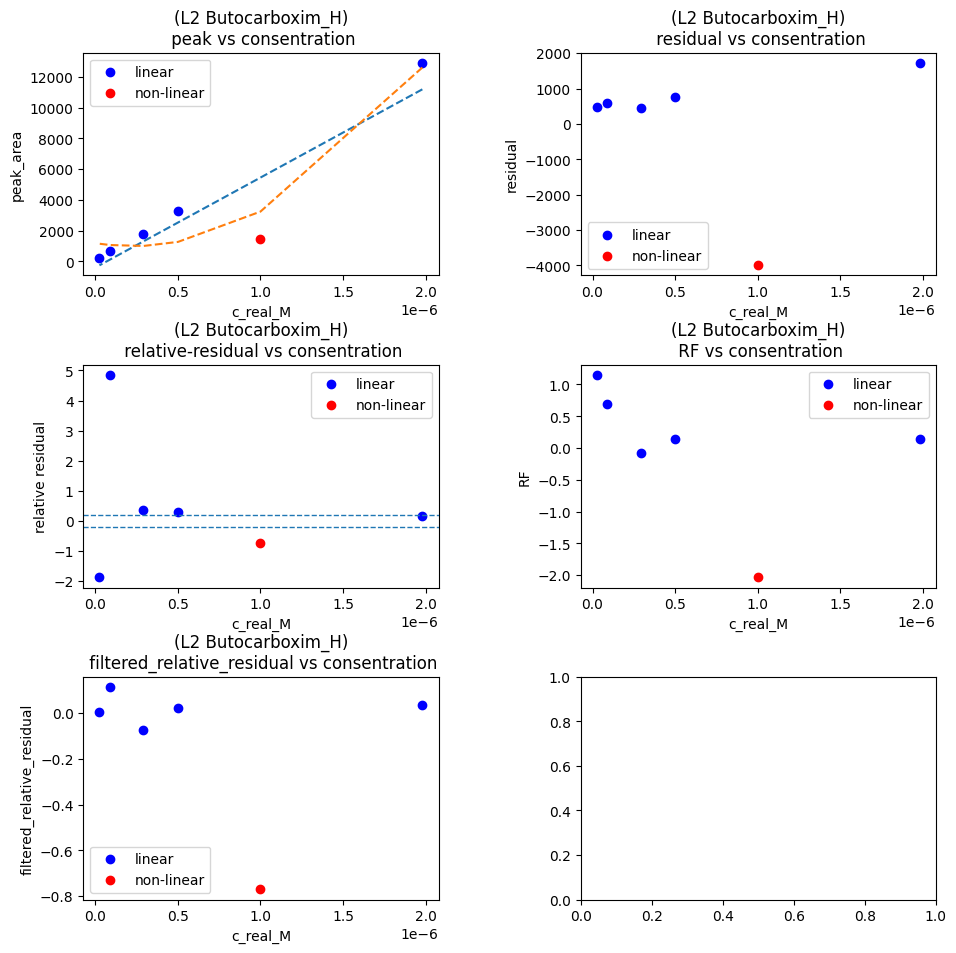

In [ ]:
df = grouped.get_group(('L2', 'Butocarboxim_H'))
plot_analysis(df)
df[['note', 'cook_dist', 'leverage', 'abs_dffits']].head()

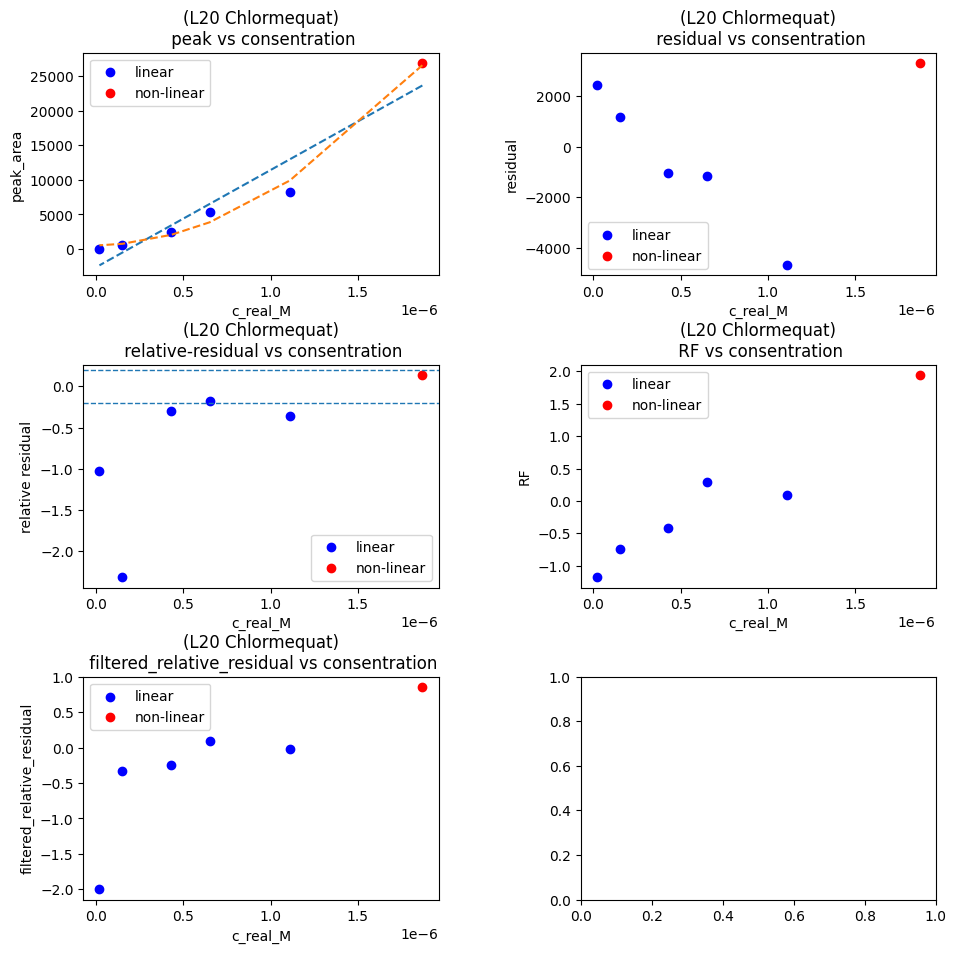

,note,cook_dist,leverage,abs_dffits
2328,non-linear,9.203563,0.652302,19.768111
2329,linear,0.799883,0.229833,1.174457
2330,linear,0.045739,0.079055,0.202374
2331,linear,0.023183,0.034491,0.145988
2332,linear,0.000472,0.004253,0.019655


In [ ]:
df = grouped.get_group(("L20", "Chlormequat"))
plot_analysis(df)
df[['note', 'cook_dist', 'leverage', 'abs_dffits']].head()

### Try to split all linear type

In [ ]:
original_df["linear_label_percentage"].value_counts()

0.000000    940
0.833333    714
1.000000    585
0.500000    584
0.666667    522
0.333333    174
0.800000    155
0.600000    125
0.750000     40
0.400000     25
Name: linear_label_percentage, dtype: int64

In [ ]:
original_df["class"].value_counts()

1.0    2339
2.0     940
0.0     585
Name: class, dtype: int64

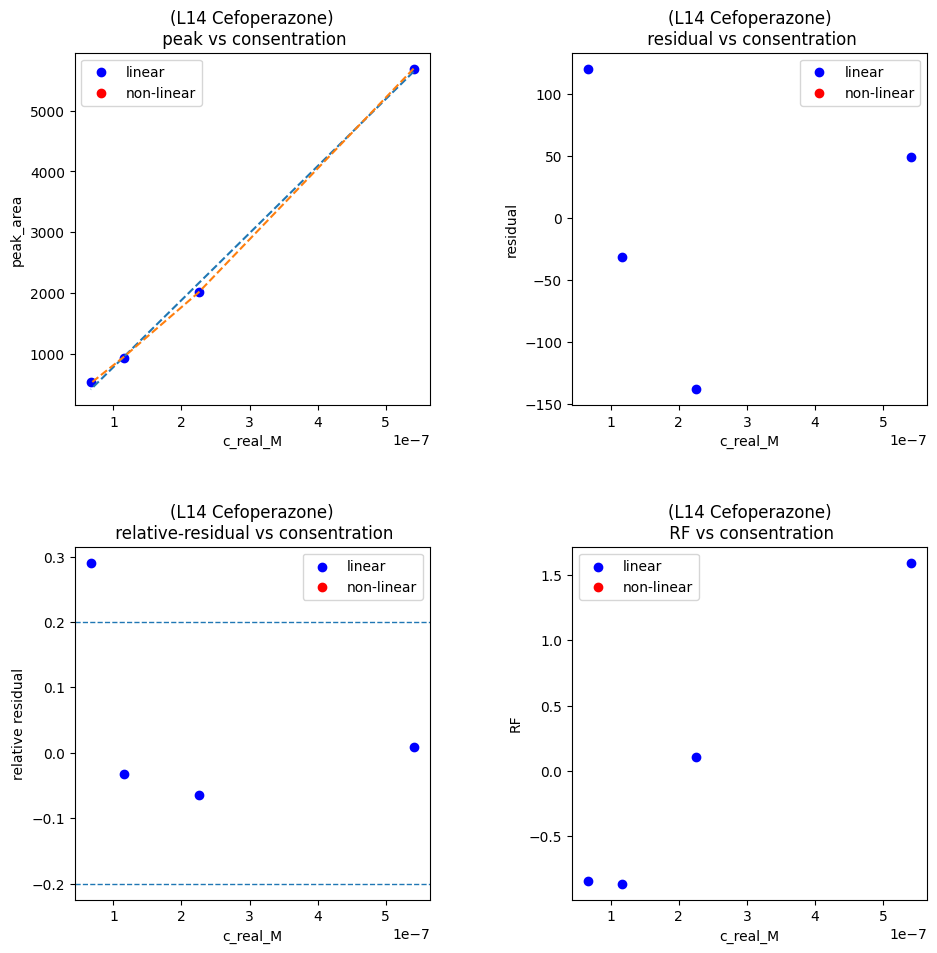

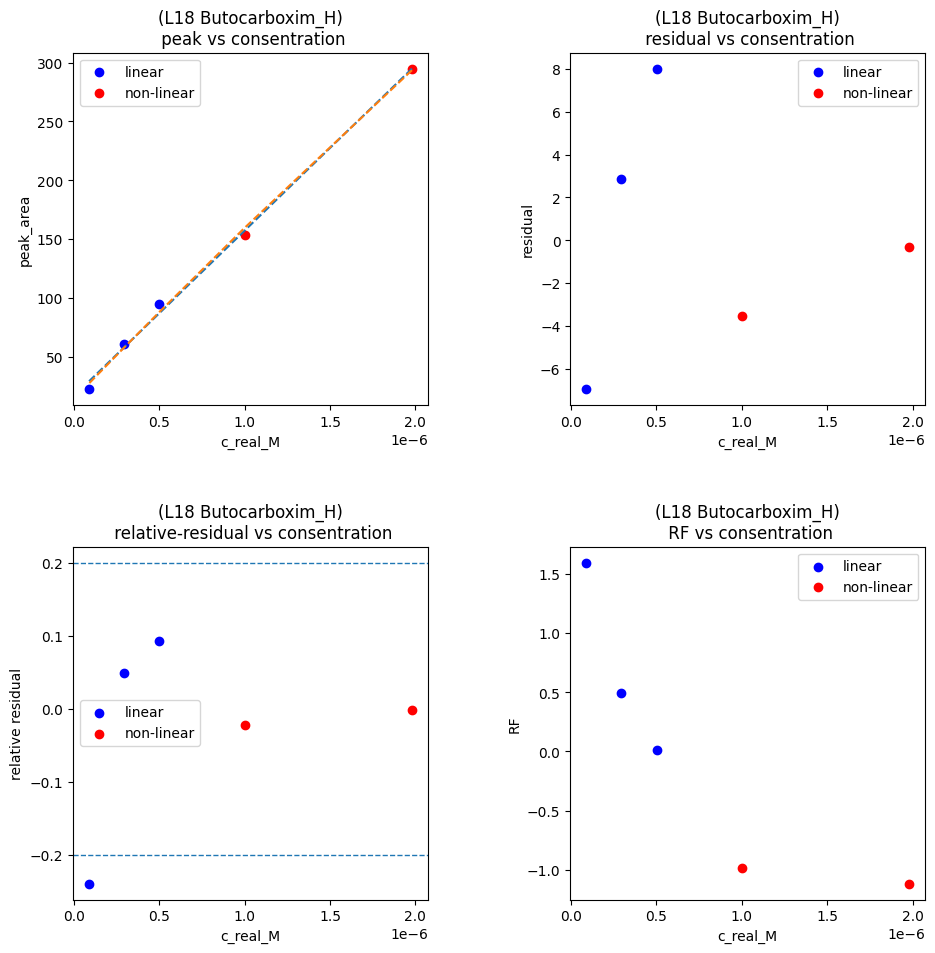

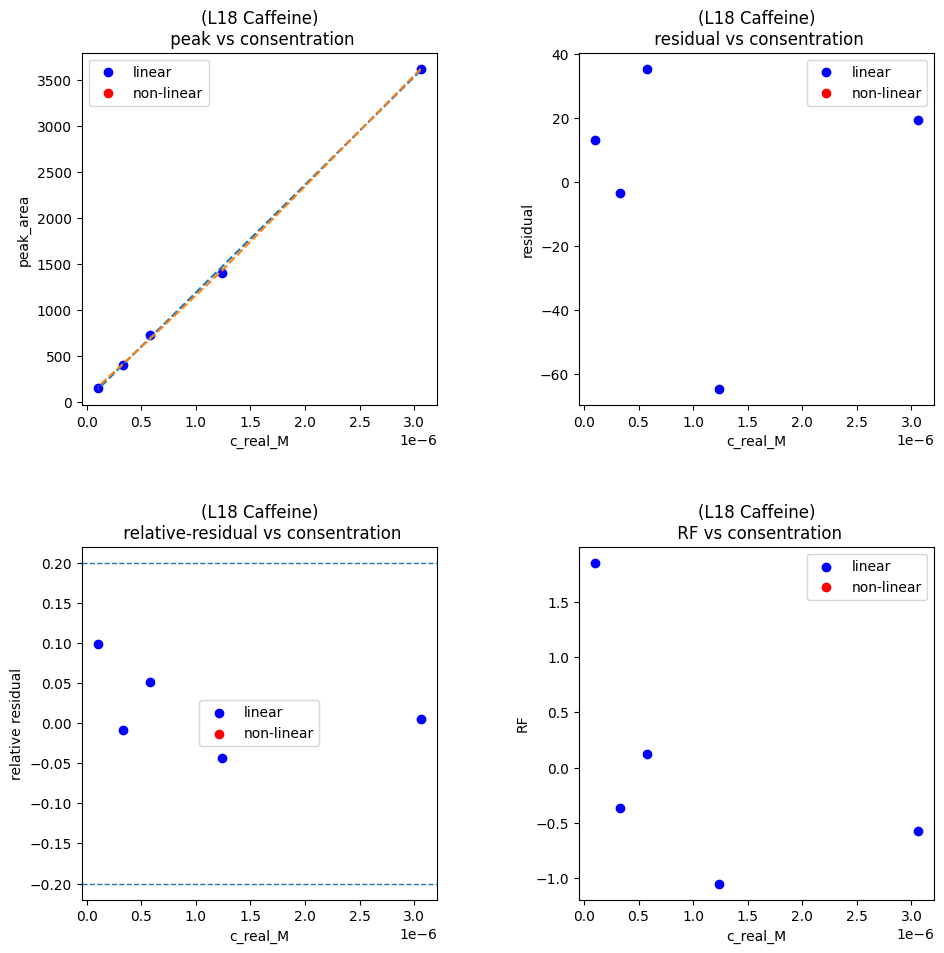

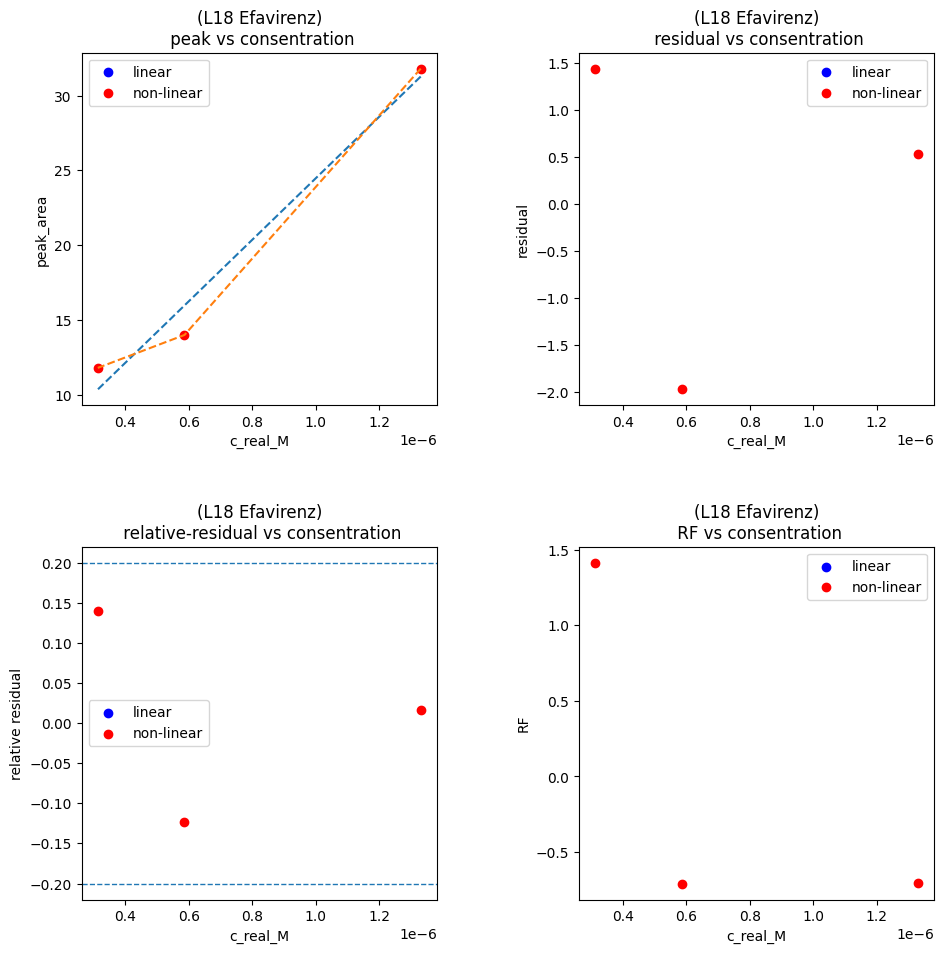

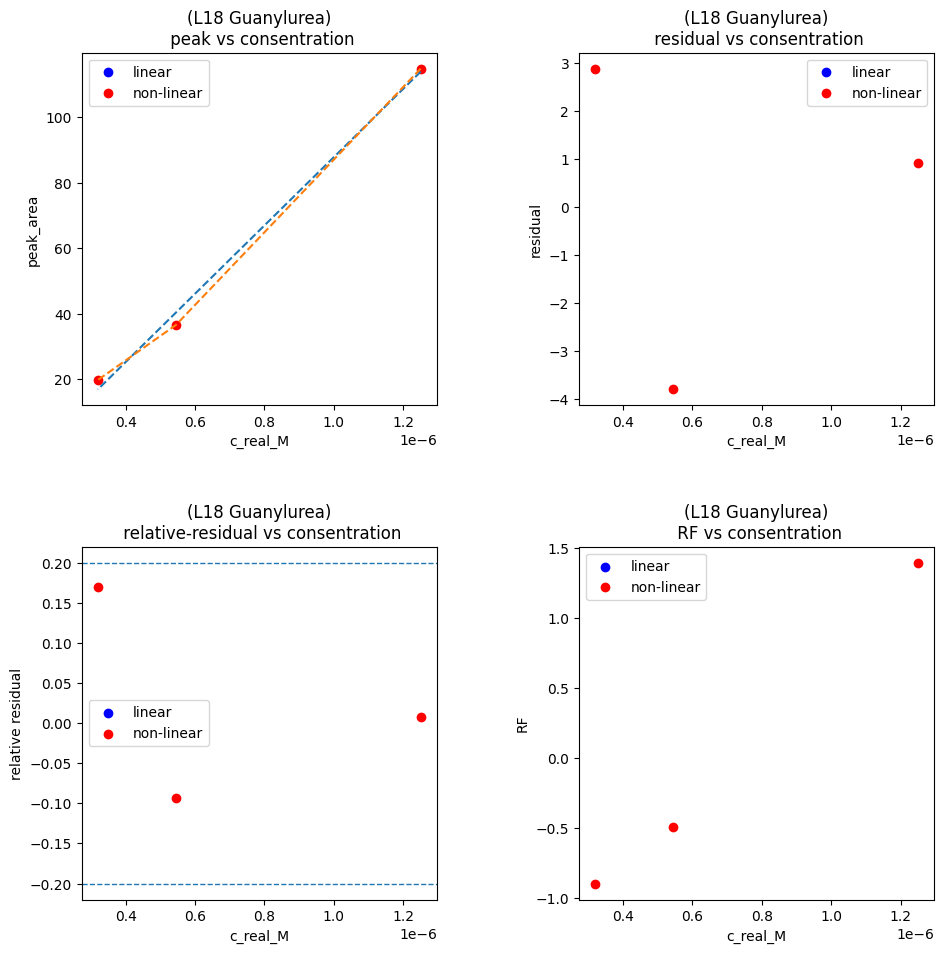

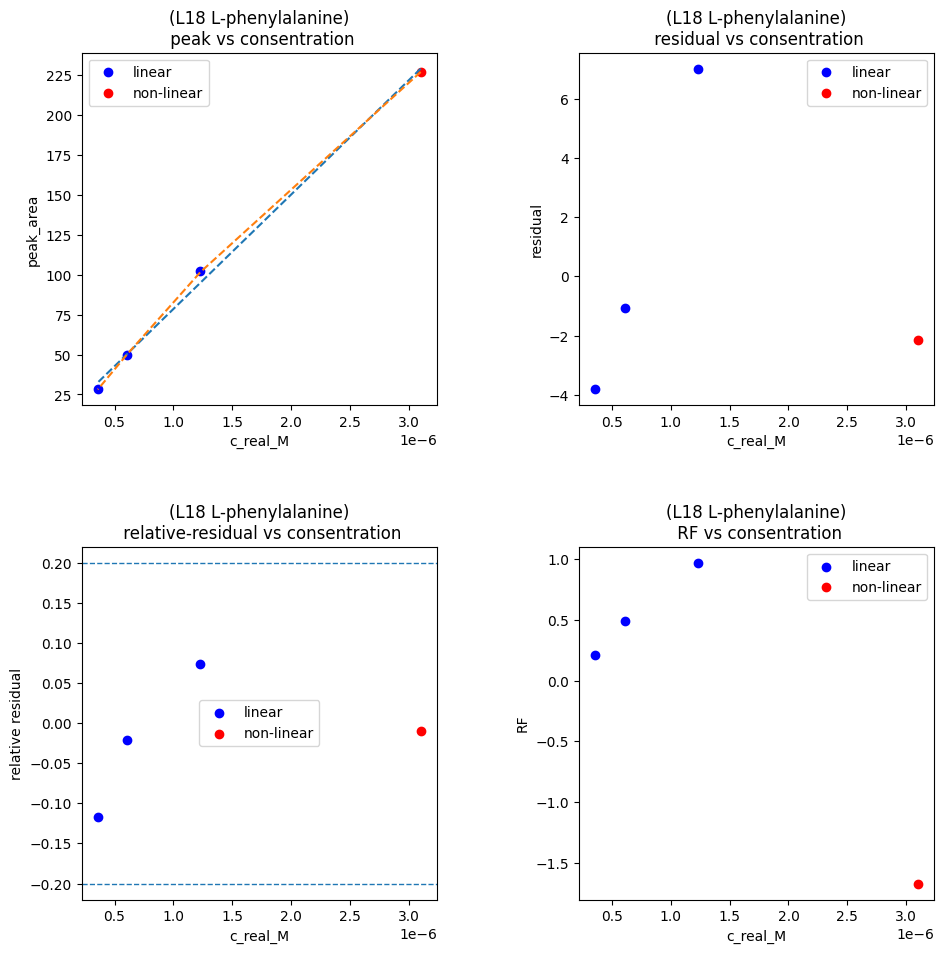

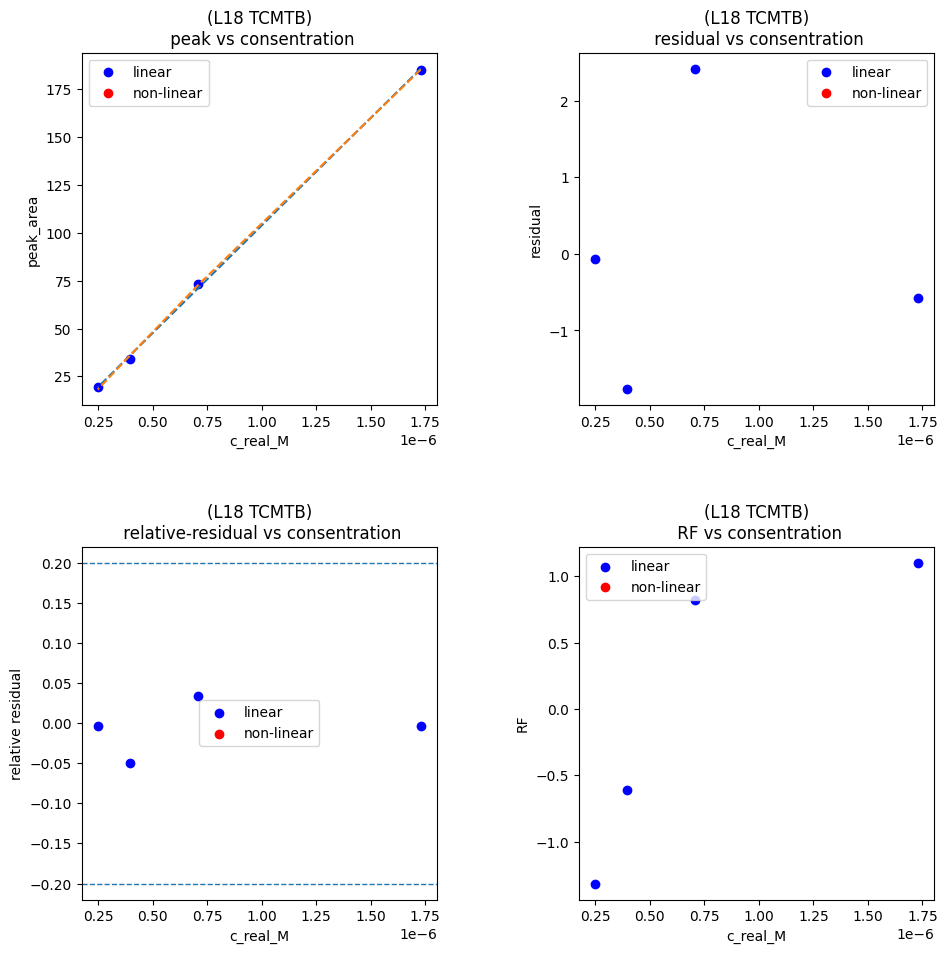

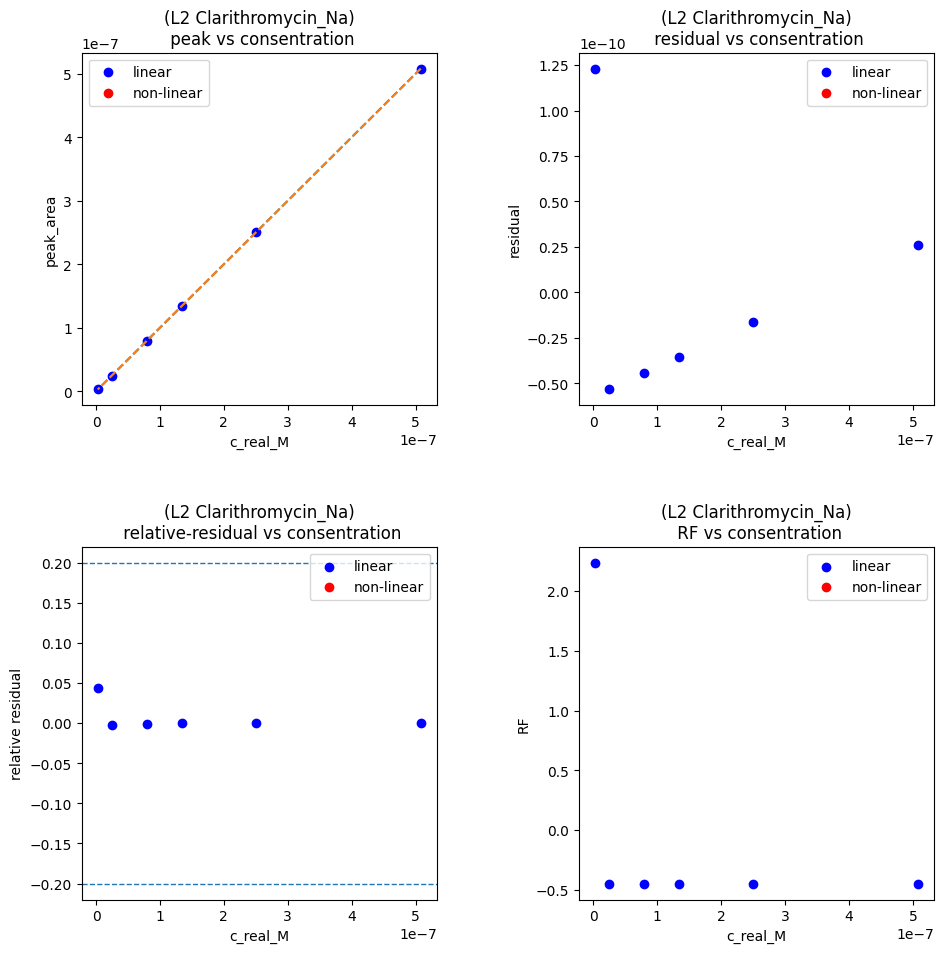

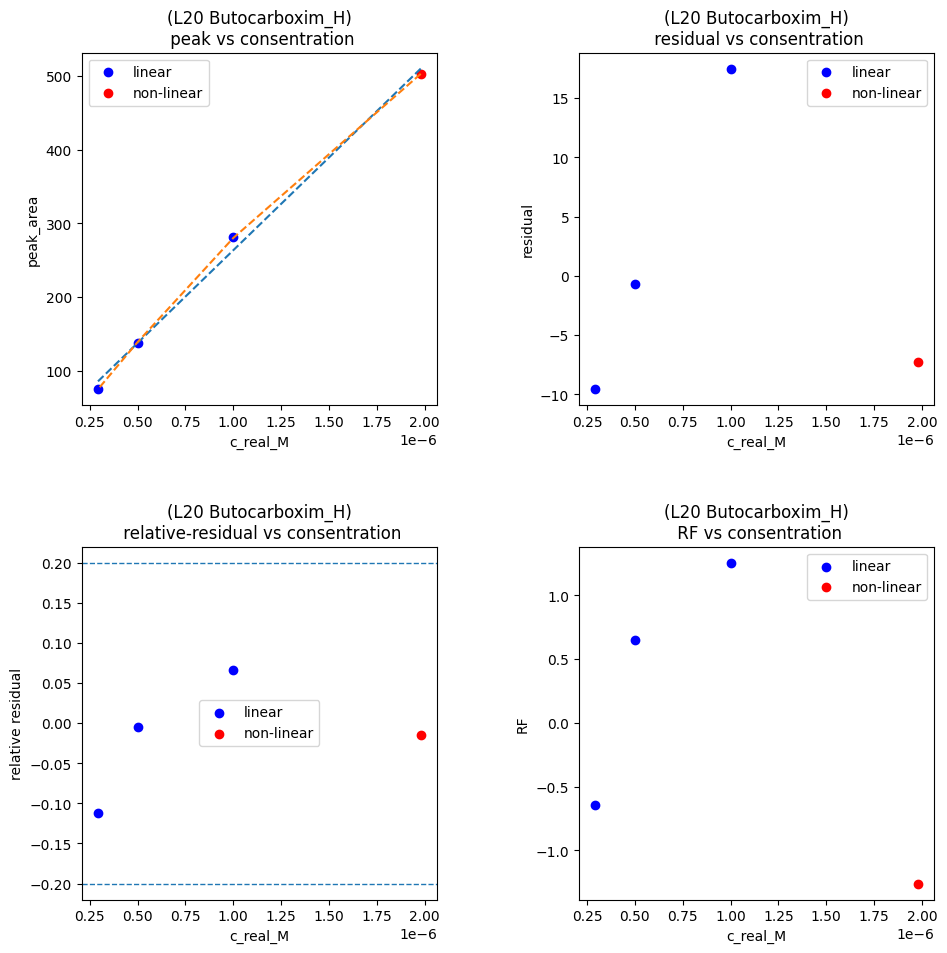

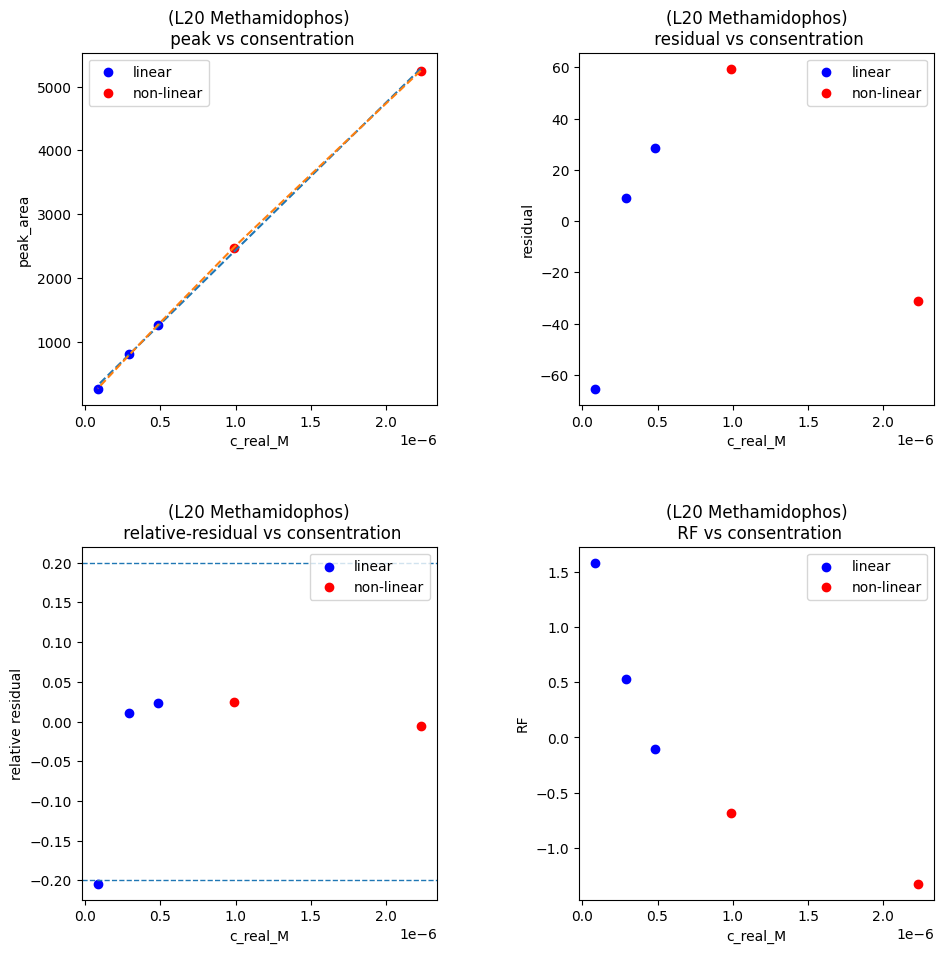

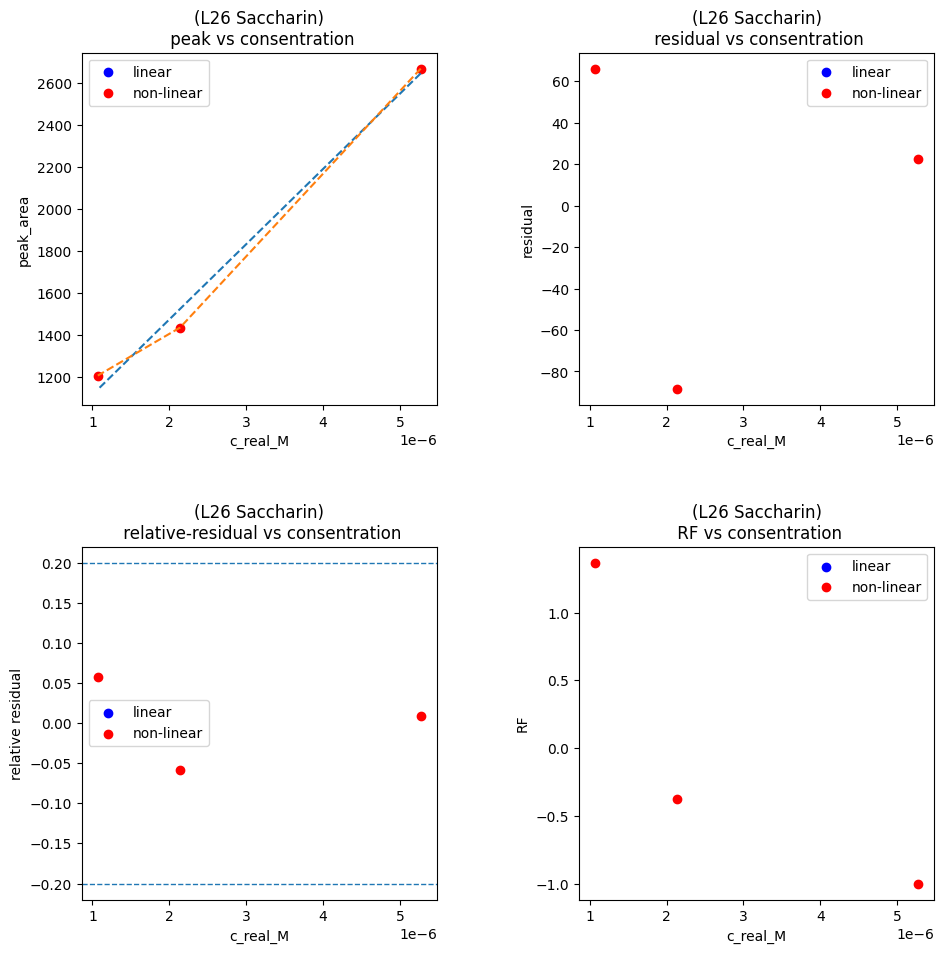

In [ ]:
for material in material_list:
  lab, compound = material
  df = grouped.get_group((lab, compound))
  if df["coef_1"].values[0] > 0:
    if df['MSE'].values[0] < 1e+4:
      if df["avg_relative_residual"].values[0] < 0.1:
        plot_analysis(df)

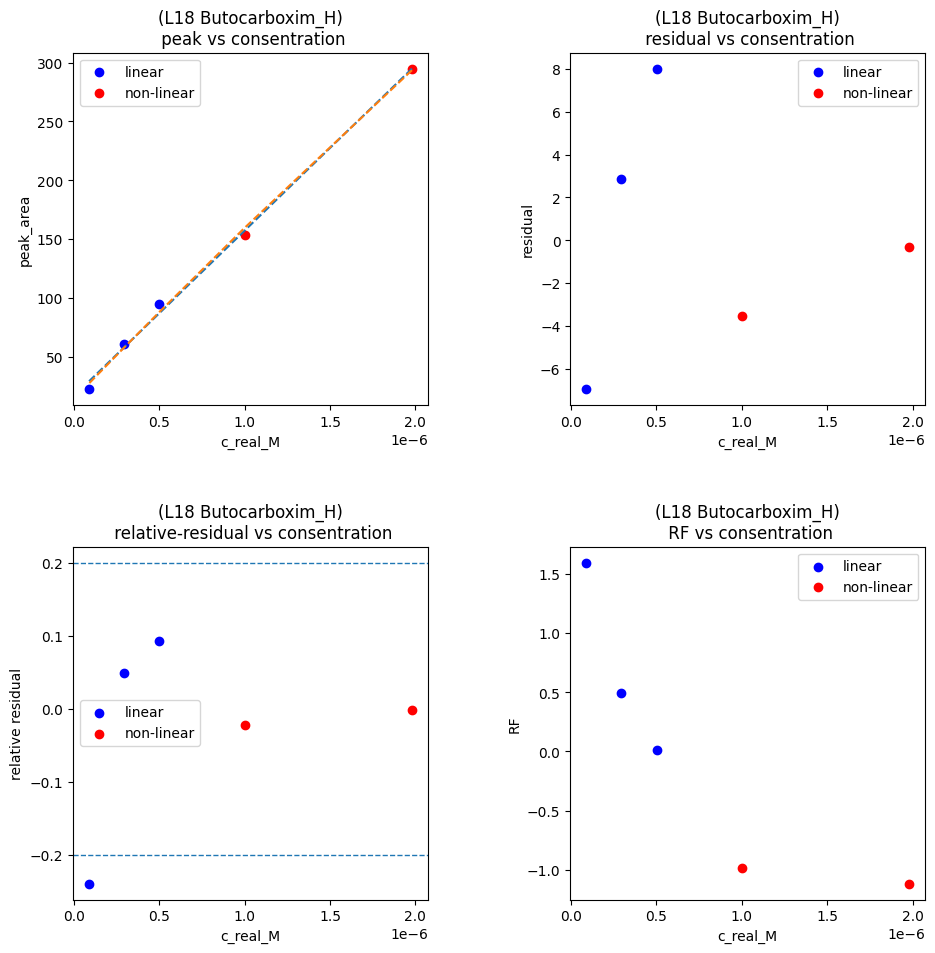

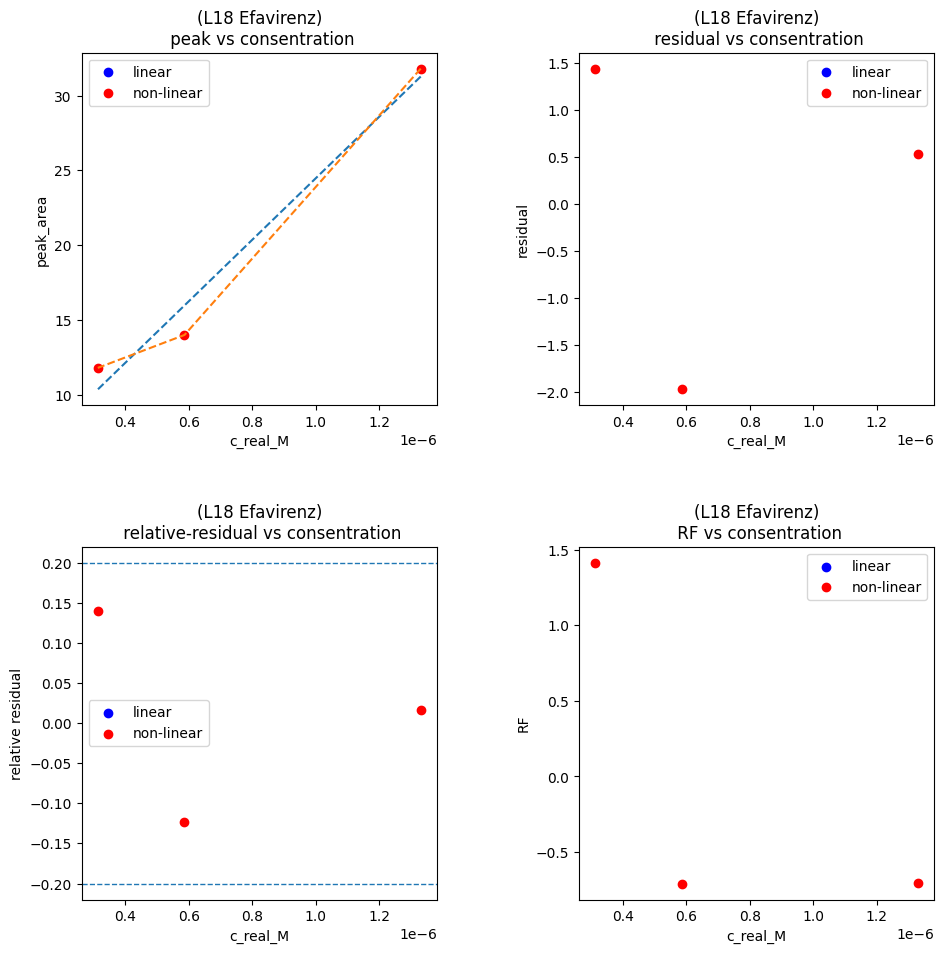

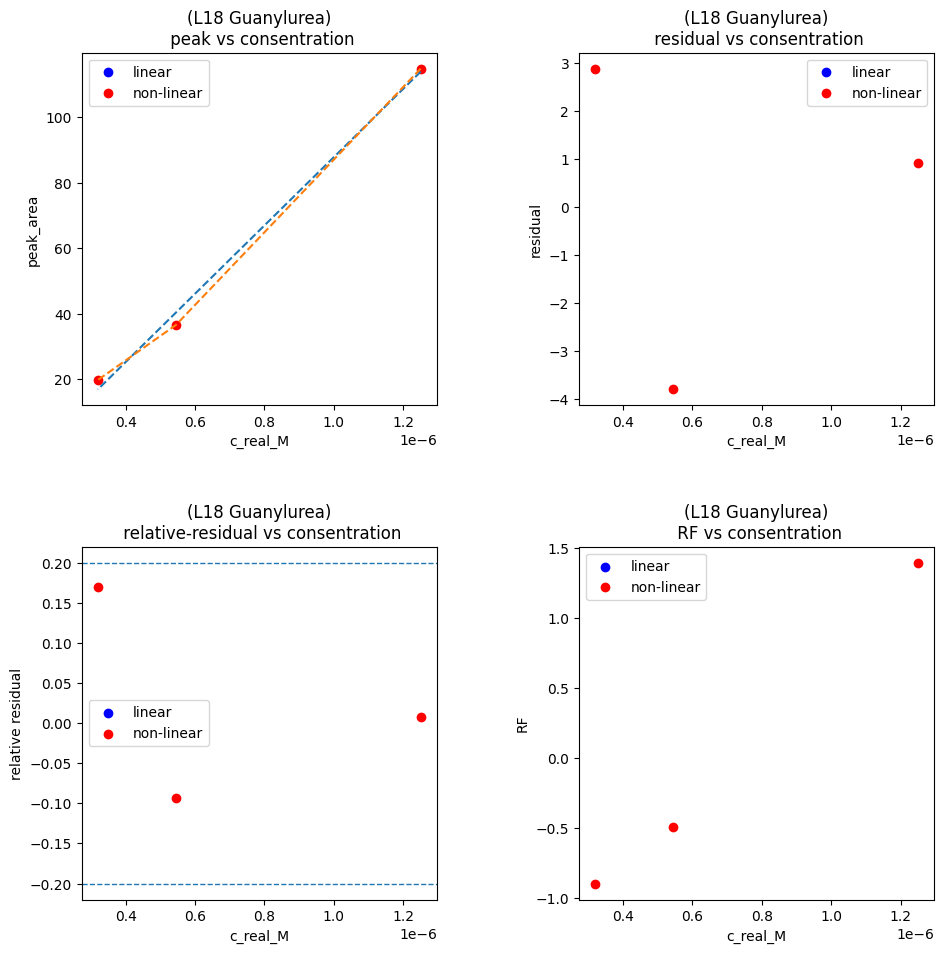

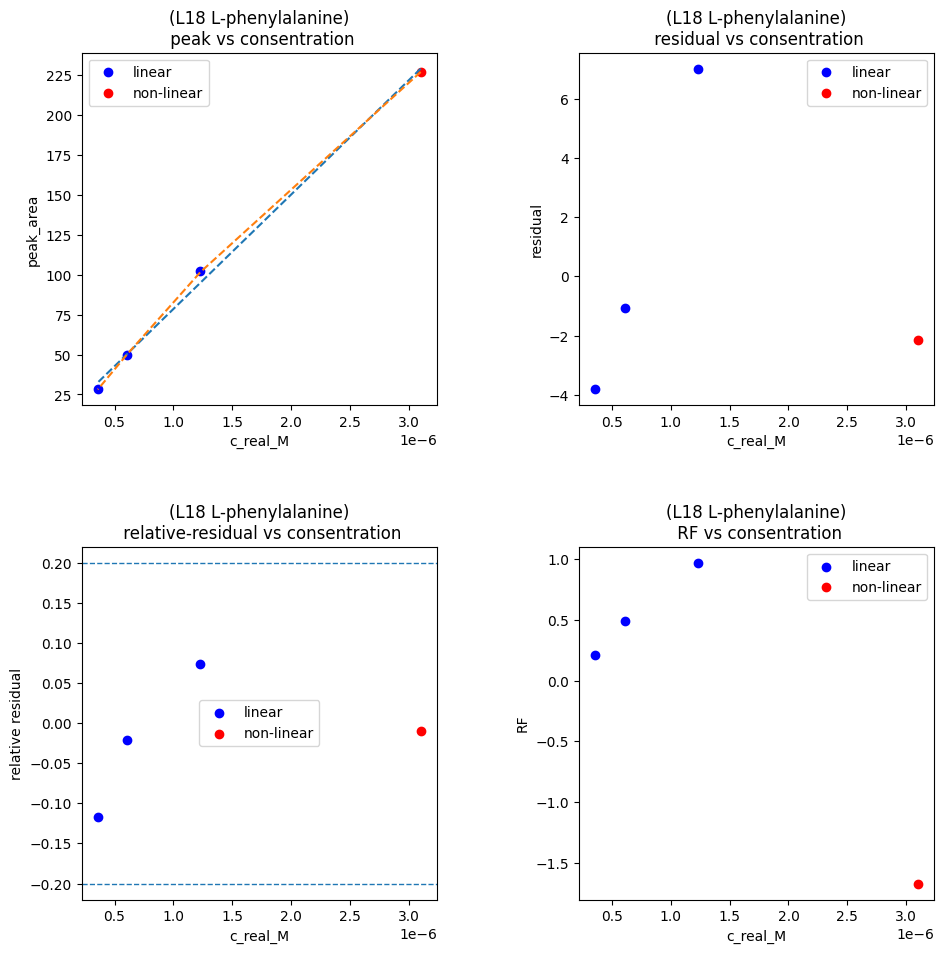

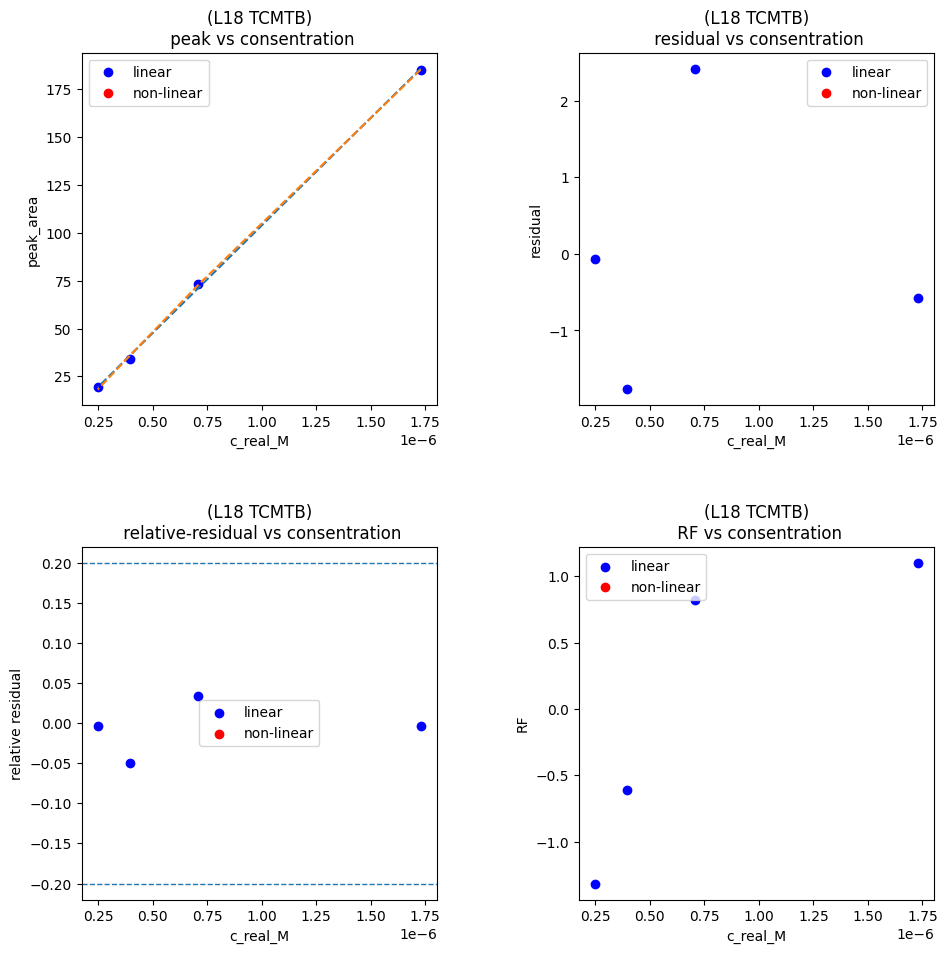

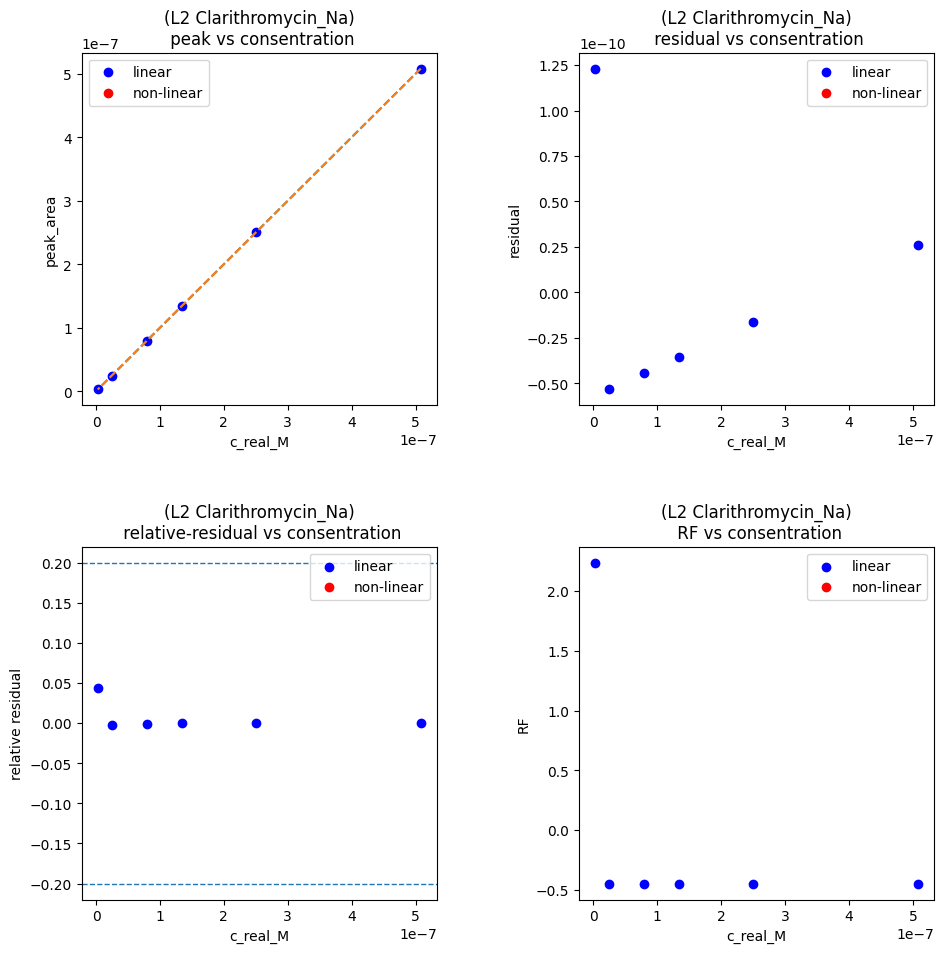

In [ ]:
for material in material_list:
  lab, compound = material
  df = grouped.get_group((lab, compound))
  if df["MSE"].values[0] < 100:
    plot_analysis(df)

### Random Plot

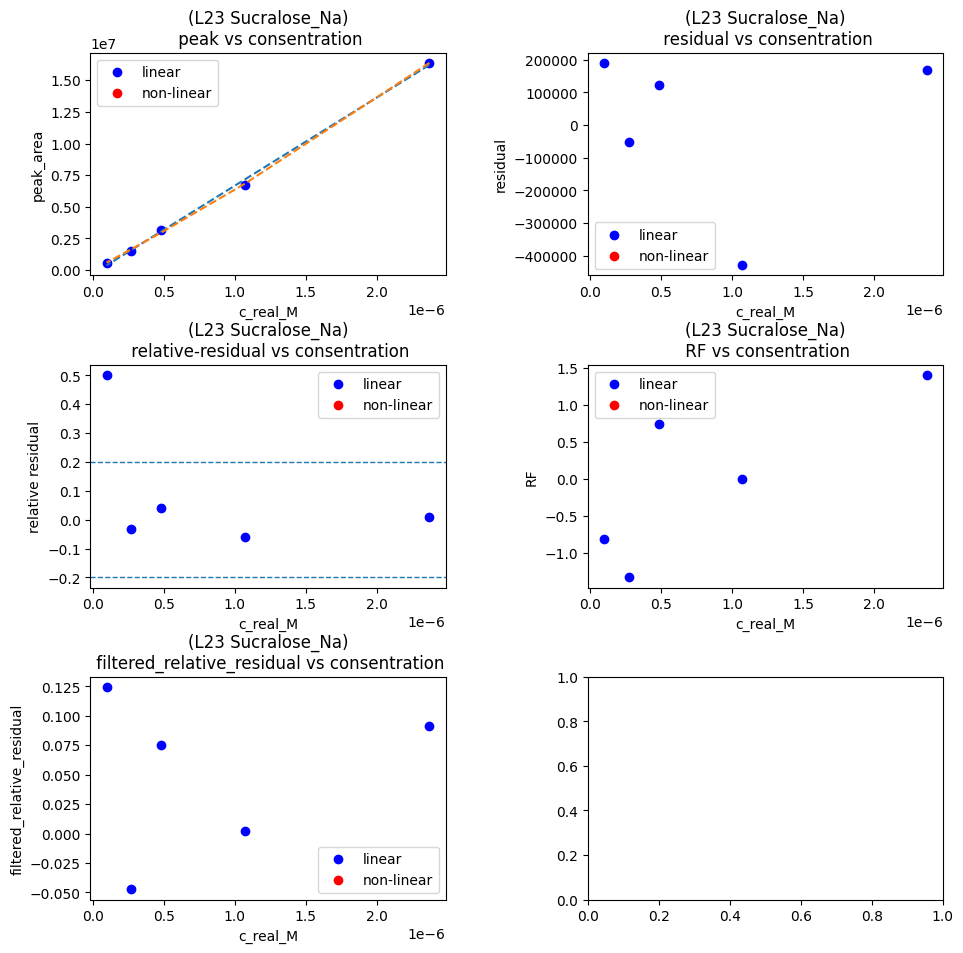

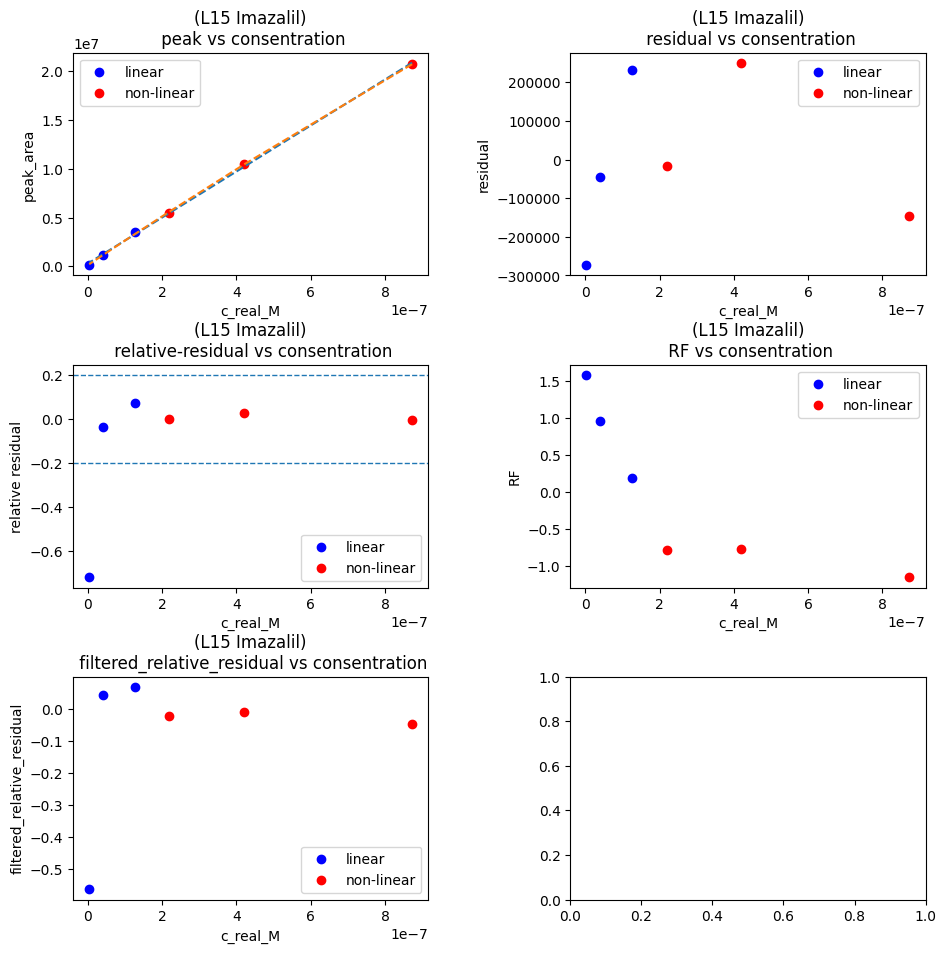

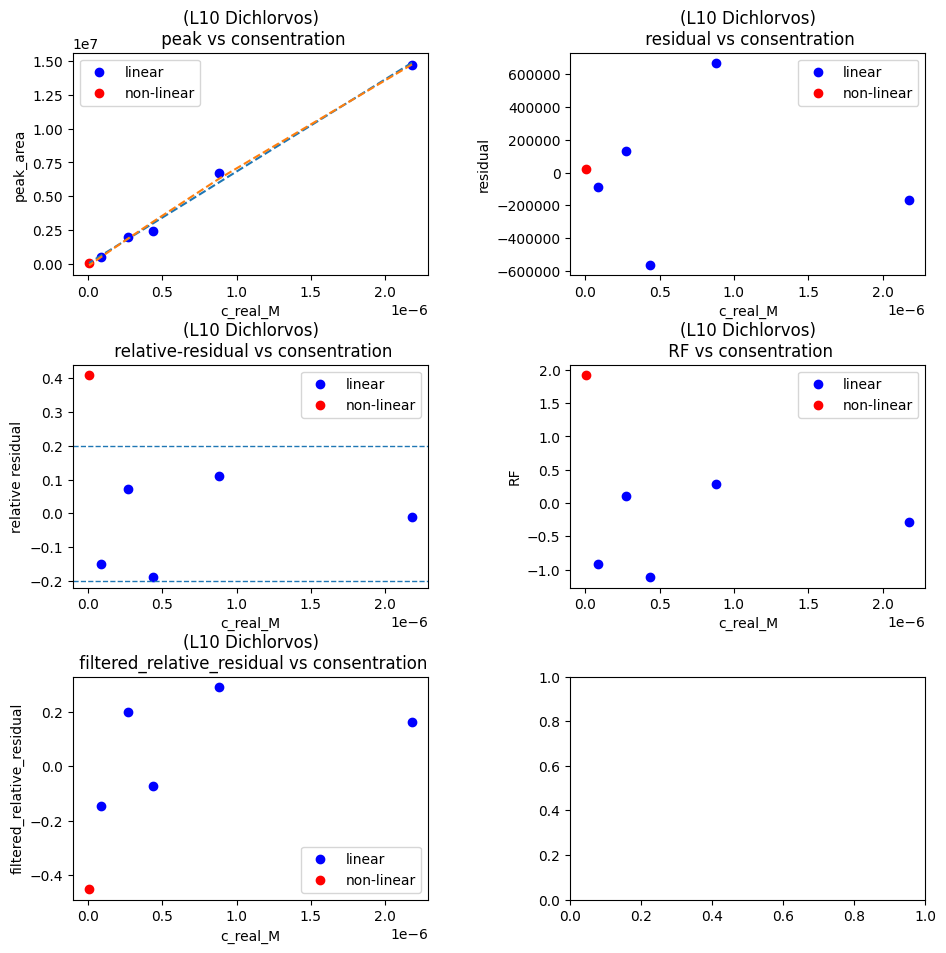

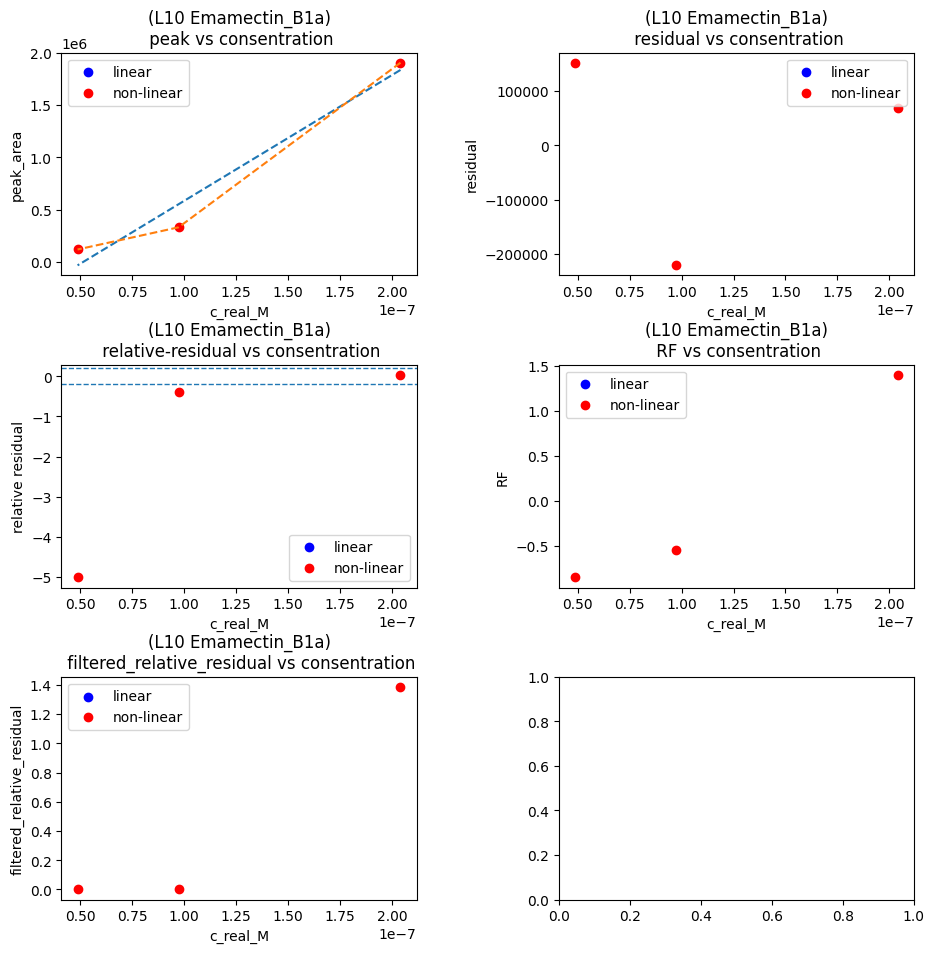

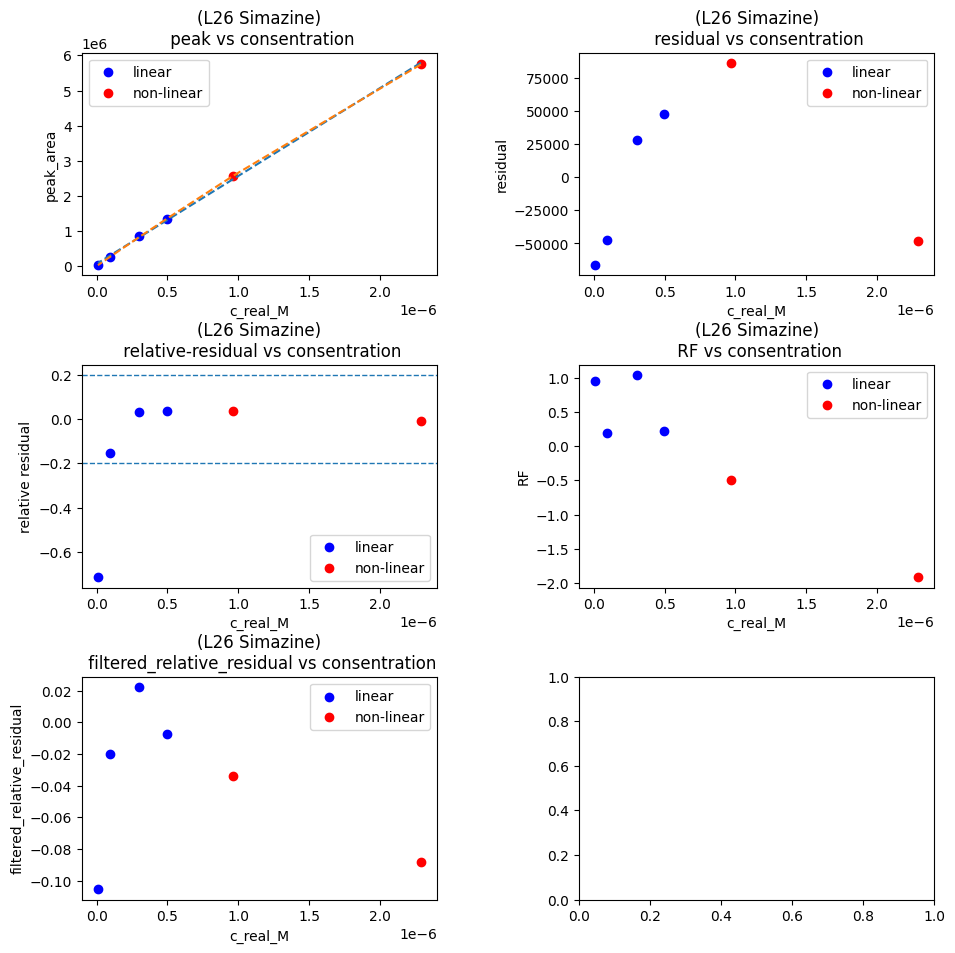

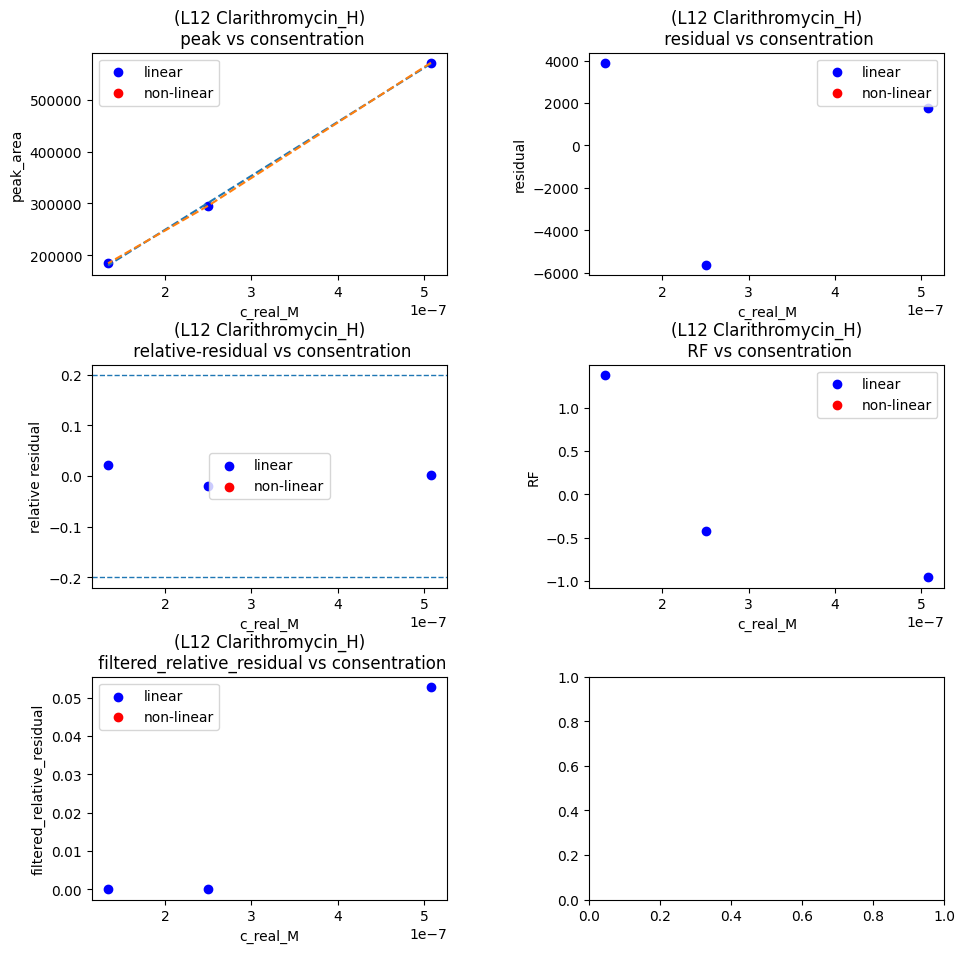

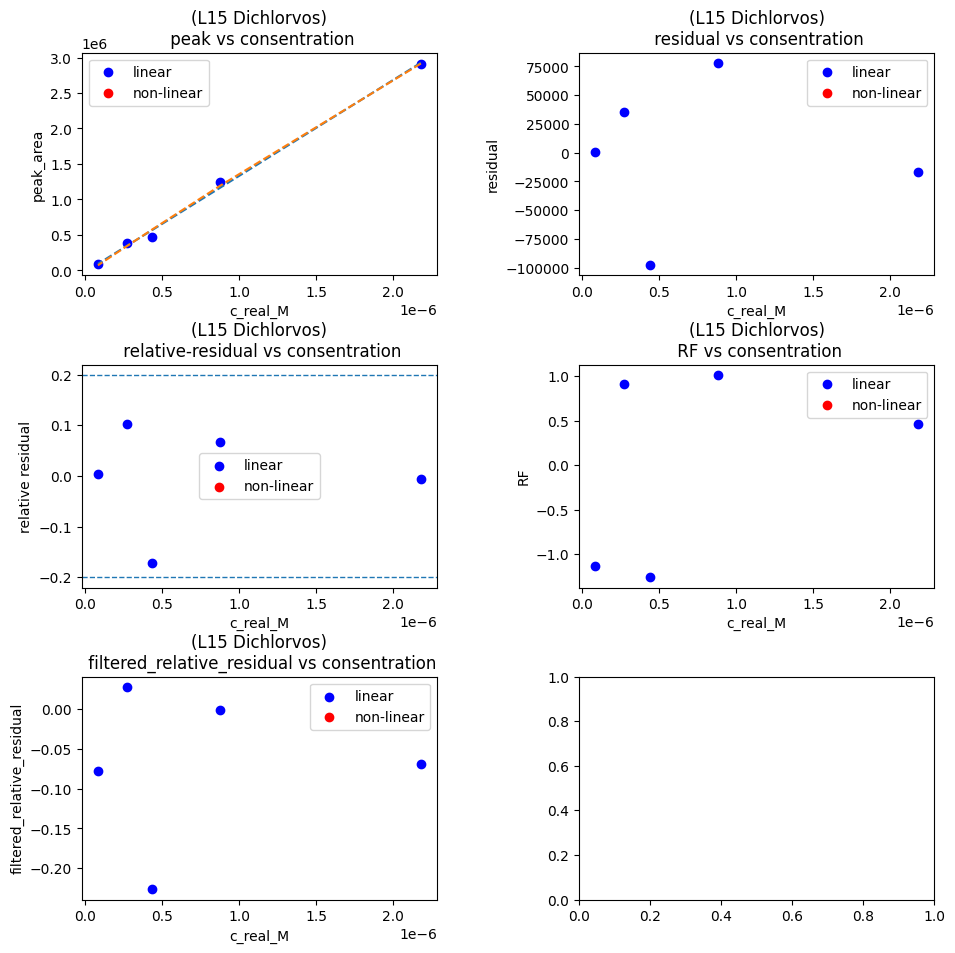

In [ ]:
import random
sampled_materials = random.choices(material_list, k=7)
for material in sampled_materials:
  lab, compound = material
  df = grouped.get_group((lab, compound))
  plot_analysis(df)

## Construct Model (Random Forest)

In [175]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

random.shuffle(material_list)
test_size = int(0.2 * len(material_list))

train_materials = material_list[test_size:]
train_df = pd.concat([grouped.get_group((lab, compound)) for lab, compound in train_materials])

test_materials = material_list[:test_size]
test_df = pd.concat([grouped.get_group((lab, compound)) for lab, compound in test_materials])

features = ["c_real_M", "peak_area", "RF", "filtered_relative_residual", "MSE", "poly_MSE", "coef_0", "coef_1", "poly_coef_1", "poly_coef_2", "abs_dffits"]

X_train = train_df[features]
y_train = train_df["note"]

X_test = test_df[features]
y_test = test_df["note"]

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=111)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8256

Classification Report:
              precision    recall  f1-score   support

      linear       0.80      0.89      0.84       394
  non-linear       0.86      0.76      0.80       357

    accuracy                           0.83       751
   macro avg       0.83      0.82      0.82       751
weighted avg       0.83      0.83      0.82       751



## Visualize Model Prediction

In [168]:
import matplotlib.pyplot as plt

def plot_prediction(df):
  colors = {'non-linear':'red', 'linear':'blue'}
  lab = df.iloc[0]["lab"]
  compound = df.iloc[0]["compound"]

  correct = df[df["predict"] == df["note"]]
  linear_correct = correct[correct["note"]=="linear"]
  nonlinear_correct = correct[correct["note"]=="non-linear"]

  failed = df[df["predict"] != df["note"]]
  linear_failed = failed[failed["note"]=="linear"]
  nonlinear_failed = failed[failed["note"]=="non-linear"]

  plt.scatter(x=linear_correct["c_real_M"], y=linear_correct["peak_area"], c=colors["linear"], alpha=1, label="[Correct] linear")
  plt.scatter(x=linear_failed["c_real_M"], y=linear_failed["peak_area"], c=colors["linear"], alpha=0.2, label="[Wrong] linear")
  plt.scatter(x=nonlinear_correct["c_real_M"], y=nonlinear_correct["peak_area"], c=colors["non-linear"], alpha=1, label="[Correct] non-linear")
  plt.scatter(x=nonlinear_failed["c_real_M"], y=nonlinear_failed["peak_area"], c=colors["non-linear"], alpha=0.2, label="[Wrong] non-linear")
  plt.legend()
  plt.plot(df["c_real_M"], df["predicted_peak_area"], "--")
  plt.title(f"({lab} {compound})\n peak vs consentration")
  plt.xlabel("c_real_M")
  plt.ylabel("peak_area")
  plt.show()

In [169]:
test_df["predict"] = y_pred
test_grouped = test_df.groupby(['lab', 'compound'])

test_material_list = list(test_grouped.groups.keys())

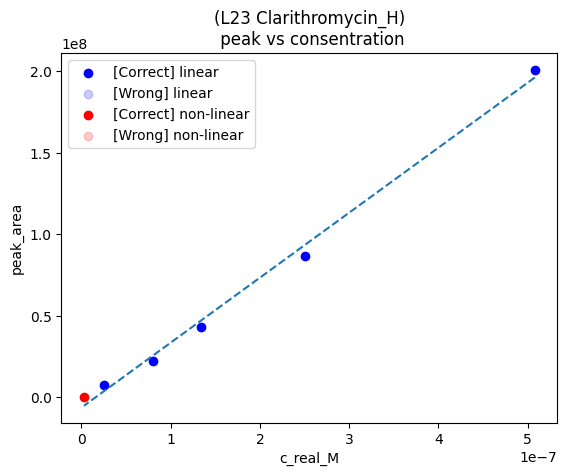

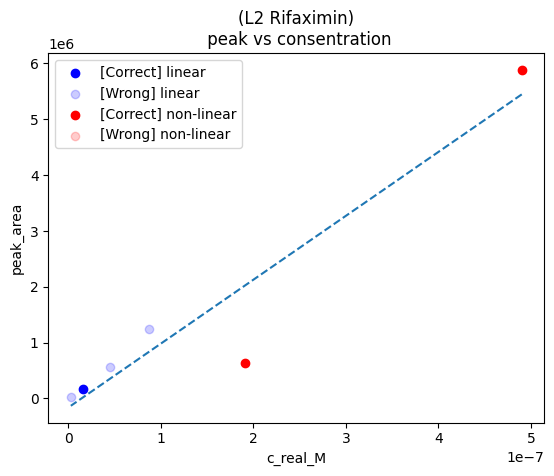

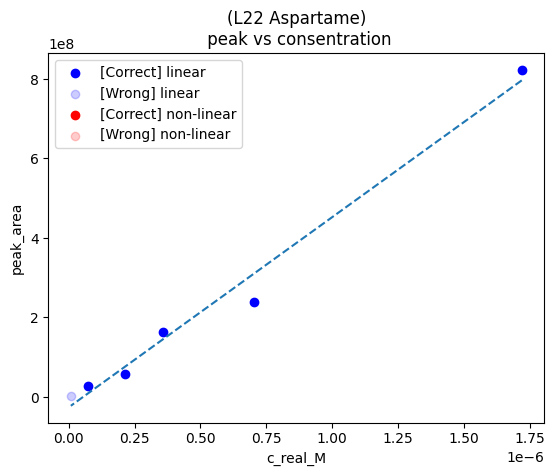

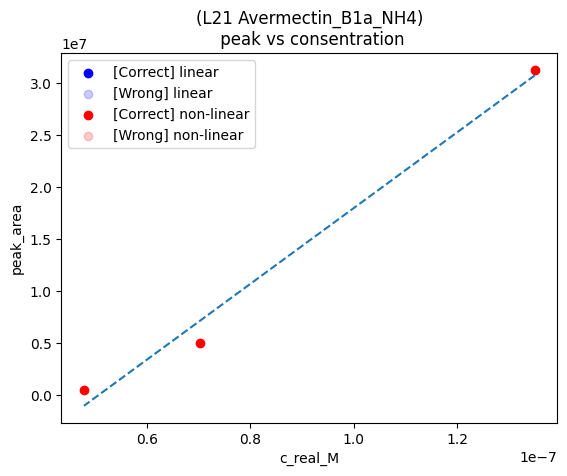

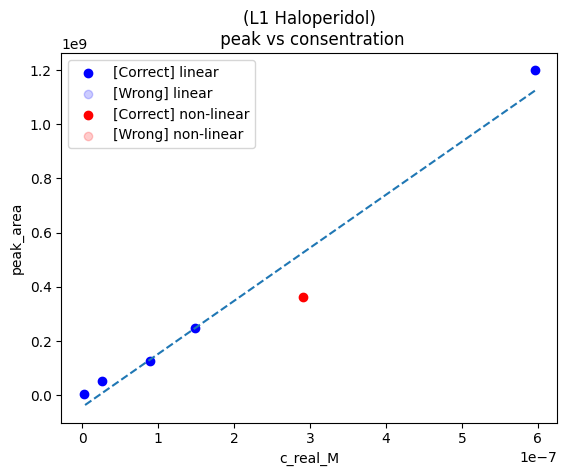

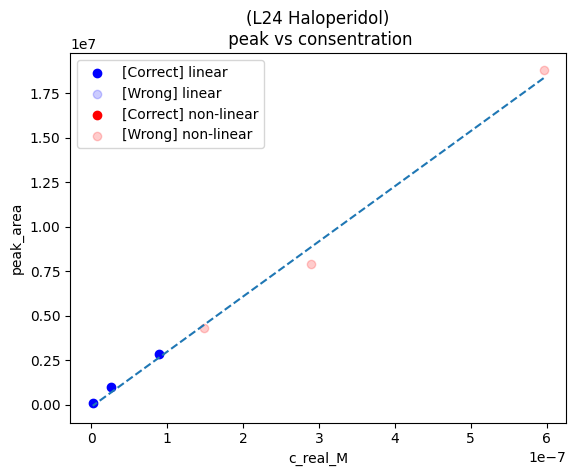

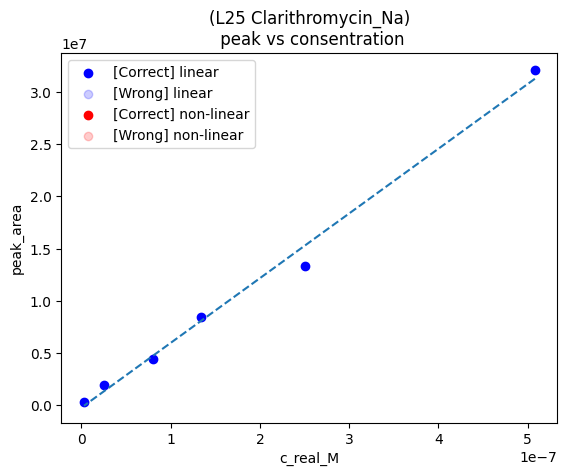

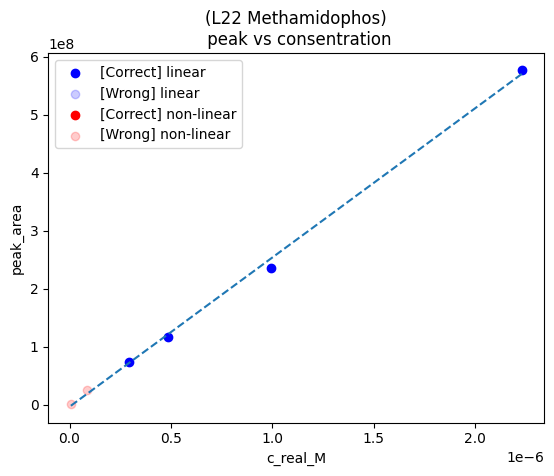

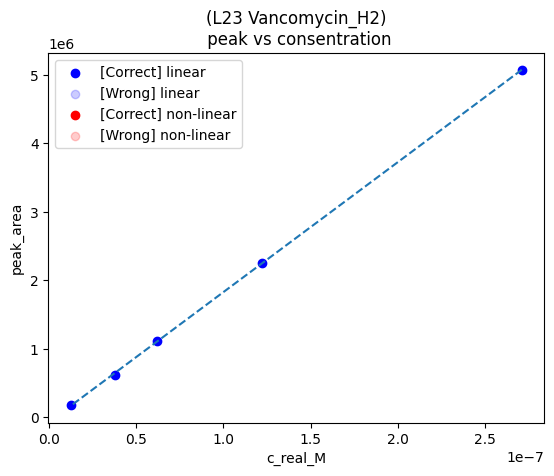

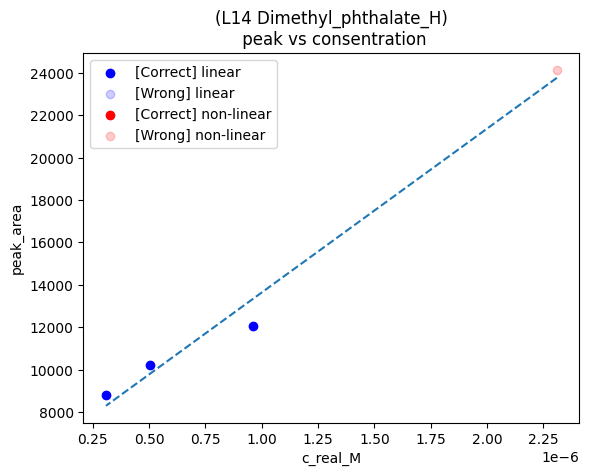

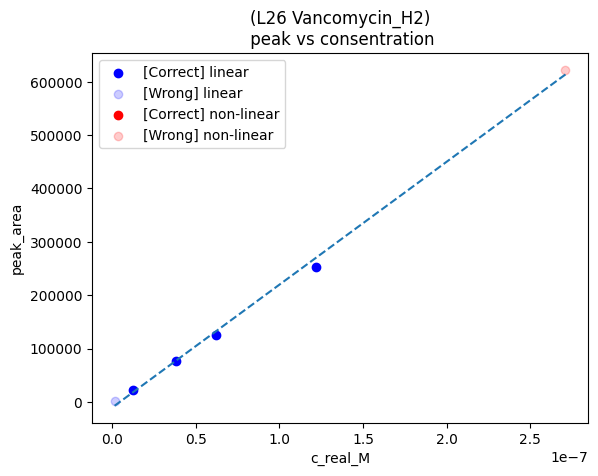

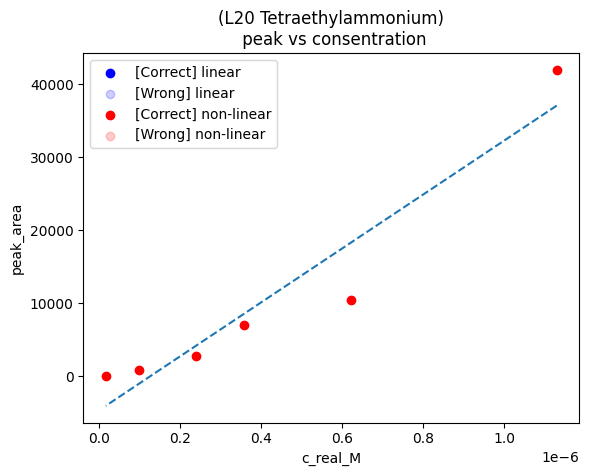

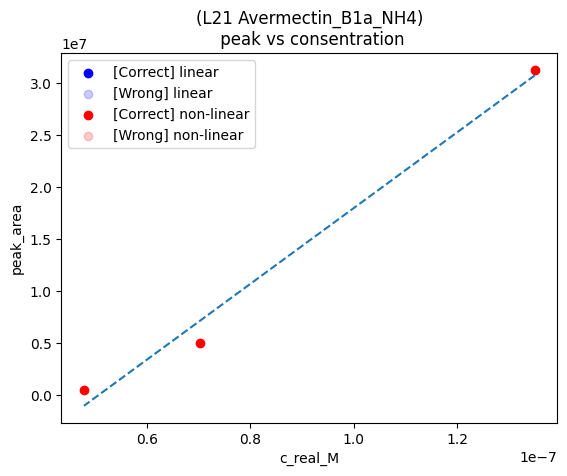

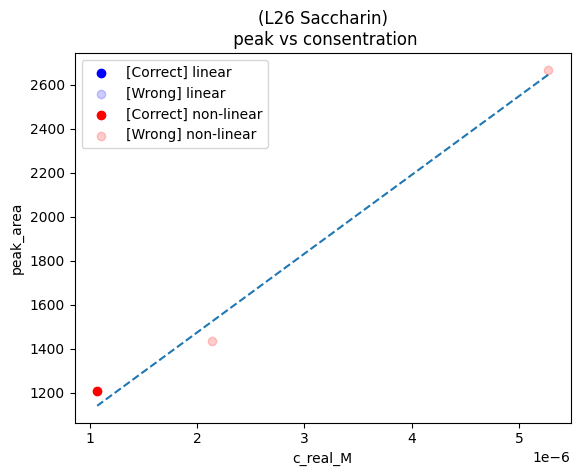

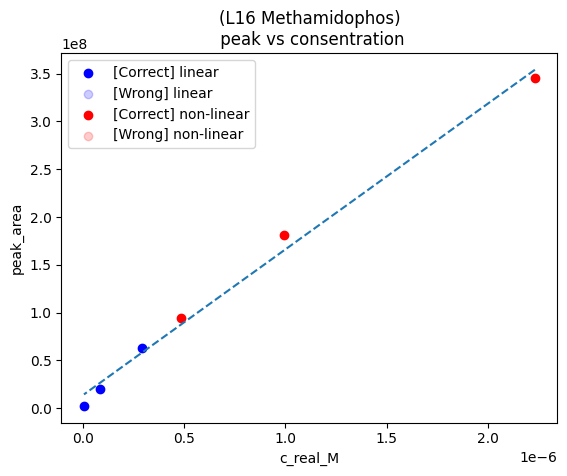

In [176]:
import random
sampled_materials = random.choices(test_material_list, k=15)
for material in sampled_materials:
  lab, compound = material
  df = test_grouped.get_group((lab, compound))
  plot_prediction(df)

## Analysis of the model predictions

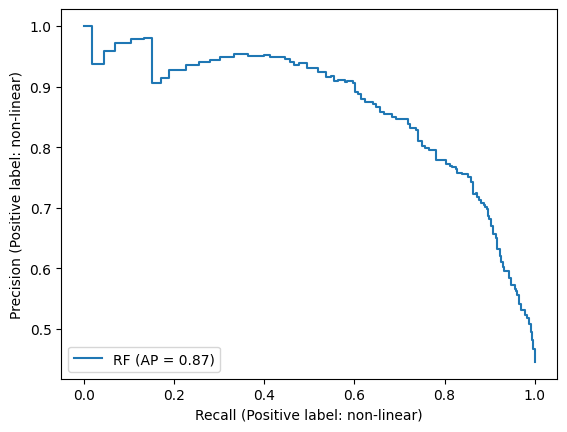

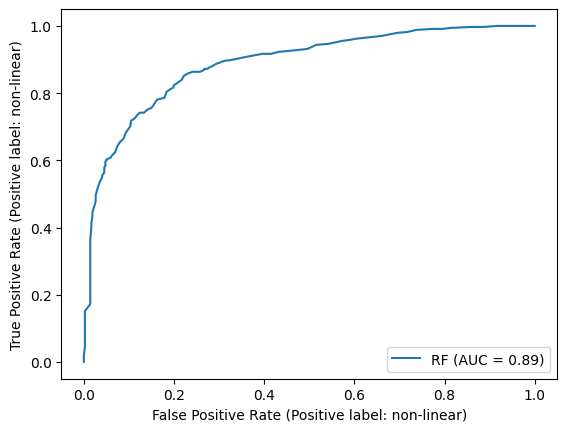

In [171]:
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test, name="RF")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="RF")

plt.show()

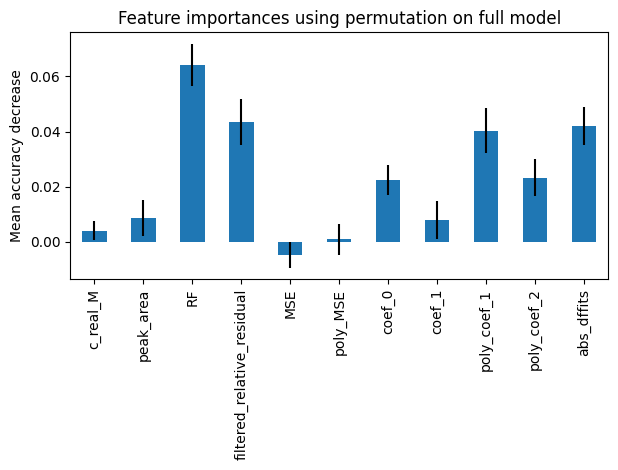

In [172]:
from sklearn.inspection import permutation_importance
import numpy as np

importances = rf_model.feature_importances_
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=111, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

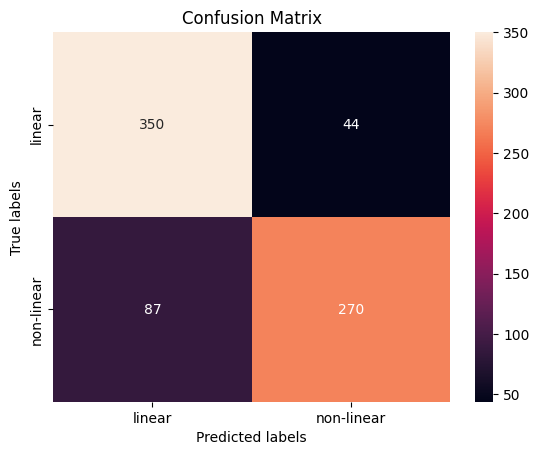

In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['linear', 'non-linear']); ax.yaxis.set_ticklabels(['linear', 'non-linear']);